여러분은 왜 개 사료가 예상보다 빨리 상하게 되는지를 파악하기위해 개 사료 회사에 고용되었습니다. 안 좋은 소식은 이 회사는 한동안 장비를 업그레이드 하지 않았습니다. 즉, 이 회사에서 사용하는 5가지 방부제의 사용 용량이 중구난방이라는 뜻입니다. 하지만 그 중에서 가장 많은 영향을 끼치는 것이 무엇일까요?<br>
이 회사에서는 먼저 4가지 방부제(A, B, C, D)가 함유된 방부제 묶음을 섞은 뒤 '필러'라는 화학물질로 마무리합니다. 식품과학자들은 A, B, C, D 방부제 중 하나가 문제를 일으키고 있다고 생각하지만, 그게 어떤 것인지 명확하게 하기위해 여러분이 고용됐습니다. "랜덤포레스트"로 어떤 방부제가 사료를 빨리 상하게 하는지 찾아보세요!

- Pres_A : 혼합물의 A비율
- Pres_B : 혼합물의 B비율
- Pres_C : 혼합물의 C비율
- Pres_D : 혼합물의 D비율
- Spoiled : 개 사료가 상했는지 여부를 나타내는 레이블.

**시나리오에서 요구하는 바를 고려하여, 머신러닝을 이용해서 문제를 풀어보세요.**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [30]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font", family = font_name)
plt.rcParams['axes.unicode_minus'] = False

In [31]:
df = pd.read_csv("./dog_food.csv")
df.head()

,A,B,C,D,Spoiled
0,4,2,12.0,3,1.0
1,5,6,12.0,7,1.0
2,6,2,13.0,6,1.0
3,4,2,12.0,1,1.0
4,4,2,12.0,3,1.0


### 데이터 파악

In [32]:
df.shape

(490, 5)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   A        490 non-null    int64  
 1   B        490 non-null    int64  
 2   C        490 non-null    float64
 3   D        490 non-null    int64  
 4   Spoiled  490 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 19.3 KB


In [34]:
df.describe()

,A,B,C,D,Spoiled
count,490.000000,490.000000,490.000000,490.000000,490.000000
mean,5.534694,5.504082,9.126531,5.579592,0.285714
std,2.951520,2.853797,2.055545,2.854837,0.452216
min,1.000000,1.000000,5.000000,1.000000,0.000000
25%,3.000000,3.000000,8.000000,3.000000,0.000000
50%,5.000000,6.000000,9.000000,6.000000,0.000000
75%,8.000000,8.000000,11.000000,8.000000,1.000000
max,10.000000,10.000000,14.000000,10.000000,1.000000


- A, B, D는 1부터 10까지 고르게 분포되어 있는 것을 보아, 데이터가 크게 치우쳐 있진 않음
- C는 5 ~ 14 사이인 것을 보아 다른 방부제와는 조금 다른 차이를 보임
- 490개 중에 약 29%의 개 사료가 상함

### 시각화

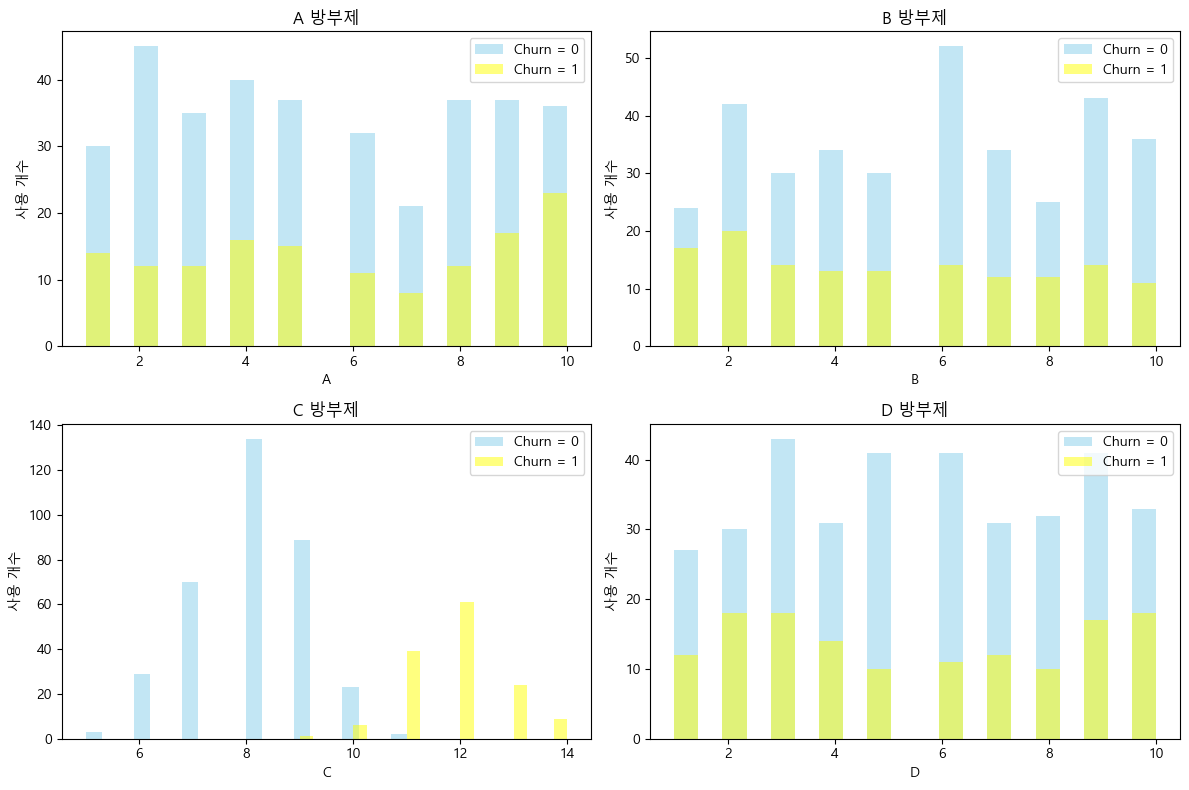

In [35]:
features = ["A", "B", "C", "D"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel() 

for i, feature in enumerate(features):
    axs[i].hist(df[df["Spoiled"] == 0][feature], bins=20, alpha=0.5, label='Churn = 0', color='skyblue')
    axs[i].hist(df[df["Spoiled"] == 1][feature], bins=20, alpha=0.5, label='Churn = 1', color='yellow')
    axs[i].set_title(f'{feature} 방부제')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('사용 개수')
    axs[i].legend()

plt.tight_layout()
plt.show()

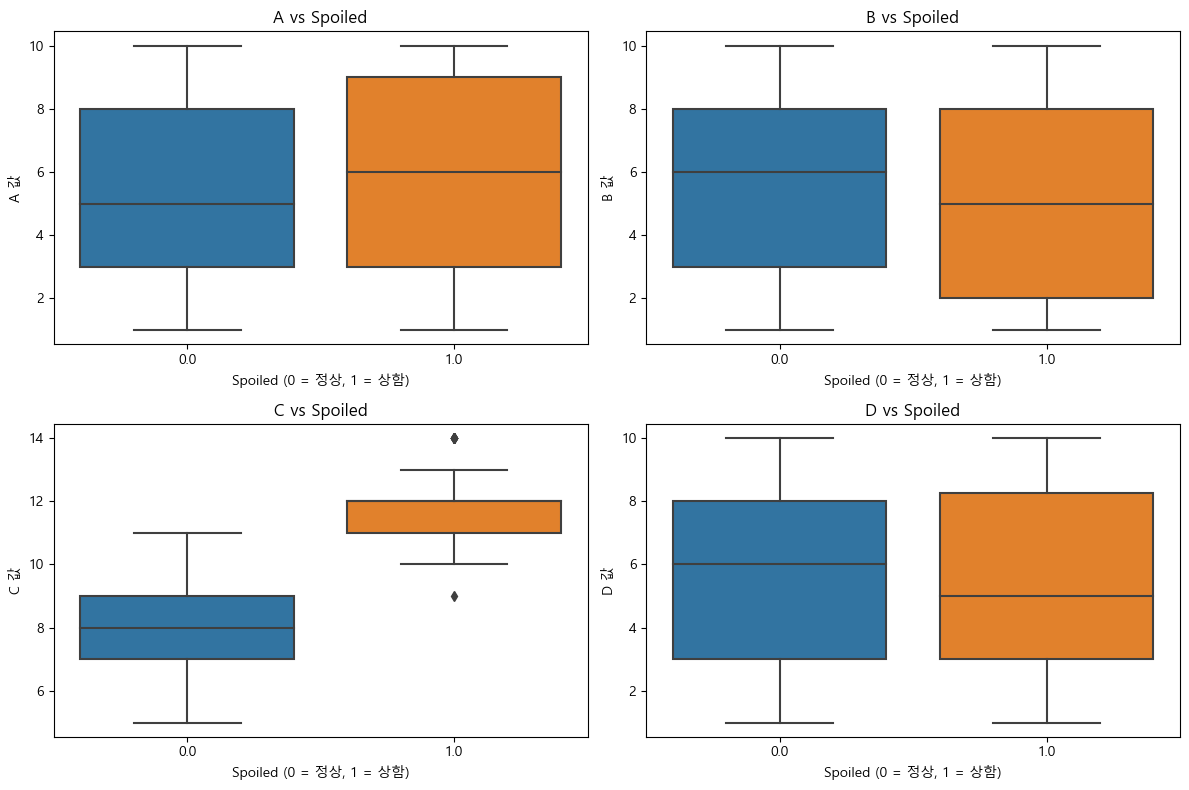

In [36]:
# boxplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
preservatives = ['A', 'B', 'C', 'D']
for ax, p in zip(axes.flatten(), preservatives):
    sns.boxplot(x='Spoiled', y=p, data=df, ax=ax)
    ax.set_title(f"{p} vs Spoiled")
    ax.set_xlabel("Spoiled (0 = 정상, 1 = 상함)")
    ax.set_ylabel(f"{p} 값")

plt.tight_layout()
plt.show()

=> A, B, D는 0과 1이 비슷한 비율을 가지는 반면 C 방부제를 사용하면 10 이상에서 상한 비율이 급증함

<Axes: >

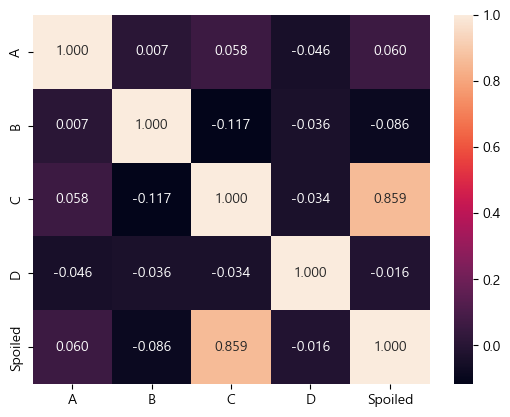

In [37]:
# 히트맵
df_heat = df.corr()
sns.heatmap(df_heat.values, cbar= True, annot= True, fmt= ".3f", yticklabels= df_heat, xticklabels= df_heat)

- "Spoiled"와 관련해 C > A > D > B

### => 따라서 C 방부제와 가장 관련이 크다고 가정됨 

### RandomForestClassifier

In [38]:
x = df.drop("Spoiled", axis = 1)
y = df["Spoiled"]

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state= 22, test_size= 0.2, stratify= y)

In [40]:
x_train.shape, x_test.shape

((392, 4), (98, 4))

In [41]:
rf = RandomForestClassifier(n_jobs= -1, random_state= 22, oob_score= True)

In [42]:
scores = cross_validate(rf, x_train, y_train, return_train_score= True, n_jobs = -1)

In [43]:
print(np.mean(scores["train_score"]), np.mean(scores["test_score"]), np.mean(scores["fit_time"]))

0.9936224334059135 0.9694255111976631 0.10413899421691894


In [44]:
gap = np.mean(scores["train_score"]) - np.mean(scores["test_score"])
gap

0.024196922208250427

In [45]:
rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=22)

In [46]:
print(rf.oob_score_)

0.9668367346938775


In [47]:
y_pred = rf.predict(x_test)

In [48]:
print(rf.feature_importances_)

[0.03401926 0.02683333 0.90354845 0.03559896]


In [49]:
feature_importances = pd.Series(rf.feature_importances_, index= x.columns).sort_values(ascending= False)
feature_importances

C    0.903548
D    0.035599
A    0.034019
B    0.026833
dtype: float64

In [50]:
feature_importance = rf.feature_importances_
feature_importance

array([0.03401926, 0.02683333, 0.90354845, 0.03559896])

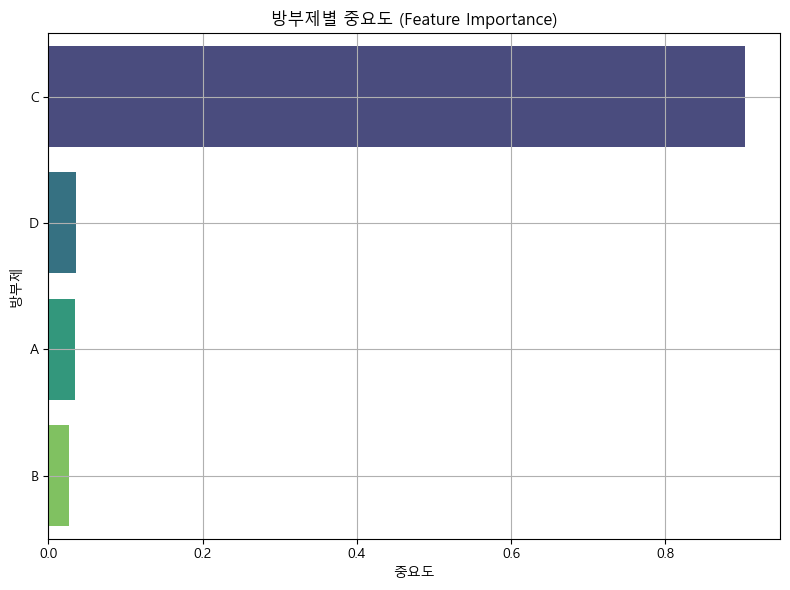

In [58]:
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette="viridis")
plt.title("방부제별 중요도 (Feature Importance)")
plt.xlabel("중요도")
plt.ylabel("방부제")
plt.grid(True)
plt.tight_layout()
plt.show()

원인 : 방부제 C 사용량이 높을수록 사료가 상할 확률이 높음
1. "Spoiled"와 상관관계에서 0.86으로 가장 높음
2. C가 10 이상일 때 상한 사료 비율이 급격하게 올라감
3. C와 중요도가 0.90354845로 가장 높은 비율을 가짐